## Demo for Loading and Combining TDC Data 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Data import *
from Triangle.TDI import *


# or just
# from Triangle import *

# Uncomment this if LaTeX is installed for better visualization
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


### Load data to directionary 
All the TDC data can be loaded as dictionaries, each containing 3 items: 
- ``eta``: the single-link measurements $\eta_{ij}$ (intermediate variable of TDI processing), which is a dictionary with keys "12", "23", "31", "21", "32", "13"; 
- ``time``: the time of data; 
<!-- - ``parameters``: the parameters of GW sources.  -->

The default unit of data is fractional frequency difference (dimensionless).

In [2]:
# h5filename should be the path of TDC data
h5filename = "/media/ps/One Touch/TDCII_Data/2_SingleSource_Dataset/data/MBHB_EHM.h5"
with h5py.File(h5filename, "r") as h5file:
    data_dict = read_dict_from_h5(h5file["/"])
data_dict

{'eta': {'12': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.16035605e-13,  2.77726185e-13, -2.32298929e-14]),
  '13': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.65483521e-13,  6.90087130e-14, -2.32063430e-14]),
  '21': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -6.96927475e-14, -1.05995254e-13, -2.45824370e-13]),
  '23': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.23270387e-13, -8.19787170e-14, -7.38620915e-15]),
  '31': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -9.71903624e-14, -6.68780444e-14, -3.80668184e-13]),
  '32': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -9.89869348e-14,  1.51064978e-13, -1.37251805e-13])},
 'time': array([0.000000e+00, 1.000000e+00, 2.000000e+00, ..., 7.775997e+06,
        7.775998e+06, 7.775999e+06])}

### Visualize raw data 
The single-link measurements are dominated by laser frequency noises, which needs to be suppressed by the subsequent TDI processing. 

Text(0.5, 1.0, 'raw single-link measurement in the time domain')

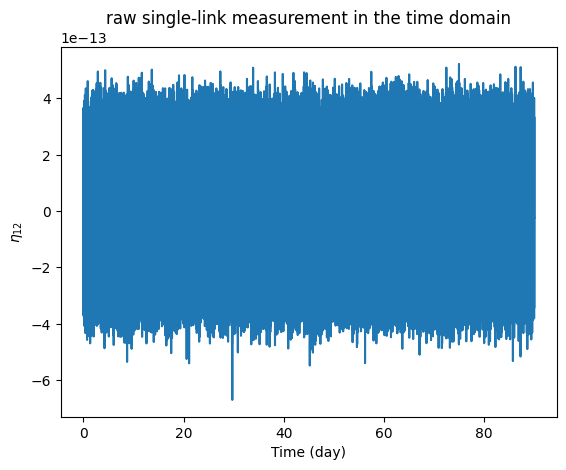

In [8]:
plt.plot(data_dict["time"] / DAY, data_dict["eta"]["12"])
plt.xlabel("Time (day)")
plt.ylabel(r"$\eta_{12}$")
plt.title("raw single-link measurement in the time domain")

Text(0.5, 1.0, 'raw single-link measurement in the frequency domain')

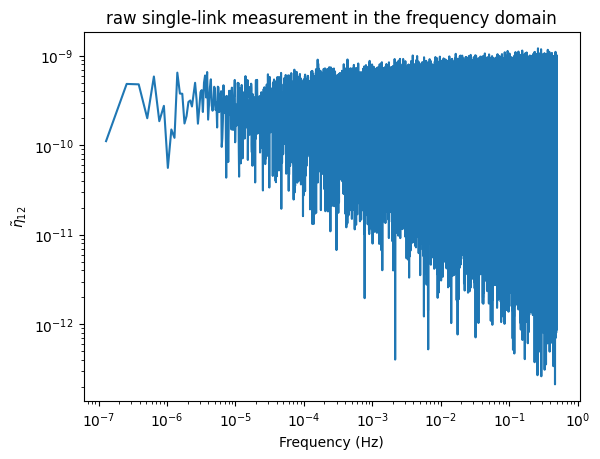

In [9]:
fsample = 1.0 / (data_dict["time"][1] - data_dict["time"][0])
ff, xf = FFT_window(data_dict["eta"]["12"], fsample=fsample, window_type="tukey", window_args_dict=dict(alpha=0.1))
plt.loglog(ff, np.abs(xf))
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\tilde{\eta}_{12}$")
plt.title("raw single-link measurement in the frequency domain")

### TDI combination 
To explore the impacts and effects of various TDI schemes in GW data analysis, all the TDC data are provided in terms of single-link measurement $\eta_{ij}$.
Since we start from $\eta_{ij}$, the first 2 steps of TDI (raw data $\rightarrow \xi_{ij}, \xi_{ij} \rightarrow \eta_{ij}$) are unnecessary.
The users only need to combine their custom TDI channels according to the methods outlined in Demo 1 and Demo 2. 
In this demo, we employ the ``FastMichelson`` method as an example.

In [10]:
# calculate the light travel times, which will be used as the delays
orbit = Orbit(OrbitDir="../OrbitData/MicroSateOrbitEclipticTCB")
ltts = dict()
for key in MOSA_labels:
    ltts[key] = orbit.LTTfunctions()[key](data_dict["time"])
ltts = MOSADict(ltts)

# prepare the input data
m = {"eta": data_dict["eta"]}

# initical TDI object. We recommand a high interpolation order of 31 to effectively suppress laser frequency noise
tdi = TDI(measurements=m, delays=ltts, fsample=fsample, order=31)

# TDI combination
tdi.FastMichelson(channel="AET") # channel can be "AET", "XYZ" or "X". This function may be slow, while it doesn't need to be run repeatedly. 

### Visualize TDI data 

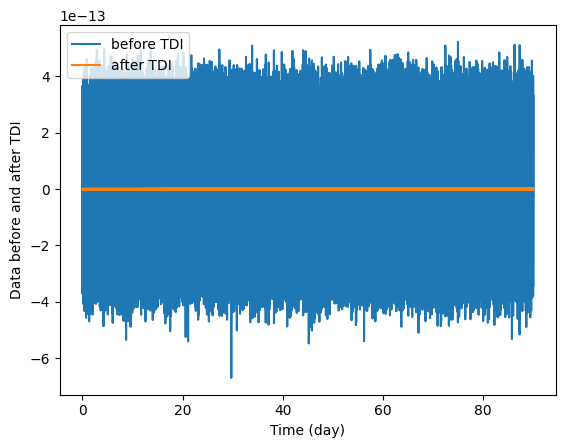

In [21]:
plt.plot(data_dict["time"] / DAY, data_dict["eta"]["12"], label="before TDI")
plt.plot(data_dict["time"][1500:-1500] / DAY, tdi.measurements["A2"][1500:-1500], label="after TDI")  # we drop 1500 seconds at the edges. Since the combination of TDI uses data at earlier time, results at the edges are invalid. 
plt.xlabel("Time (day)")
plt.ylabel("Data before and after TDI")
plt.legend(loc="upper left")

When plotted in the frequency domain, it is evident that a MBHB signal exceeds the noise floor in the mHz to 10mHz band. To clearly show the waveform in the time domain, a further downsampling process (e.g. fsample = 1 Hz to fsample = 0.2 Hz) is required to remove the high-frequency noises and interpolation errors. 

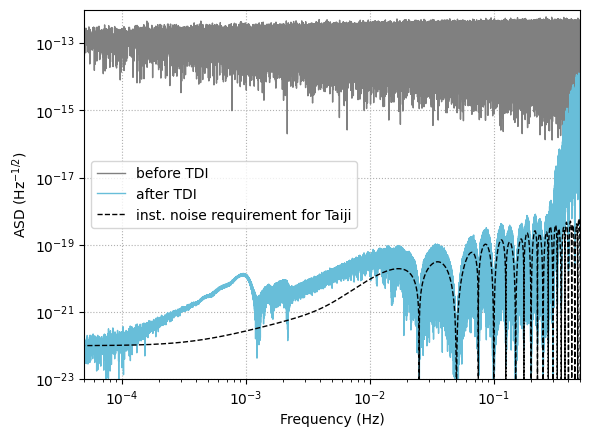

In [22]:
# ASD before TDI 
ff, xf = PSD_window(data_dict["eta"]["12"], fsample, 1, window_type="tukey", window_args_dict=dict(alpha=0.1))
plt.loglog(ff, np.sqrt(xf), color="grey", linewidth=1, label="before TDI")

# ASD after TDI 
ff, xf = PSD_window(tdi.measurements["A2"][1500:-1500], fsample, 1, window_type="tukey", window_args_dict=dict(alpha=0.1))
plt.loglog(ff, np.sqrt(xf), color=BLUE, linewidth=1, label="after TDI")

# theoretical ASD of A2 channel 
PSD = TDIPSDs()
plt.loglog(ff, np.sqrt(PSD.PSD_A2(ff)), color="k", linewidth=1, linestyle="--", label="inst. noise requirement for Taiji")

plt.xlim(5e-5, 0.5)
plt.ylim(1e-23, 1e-12)
plt.grid(linestyle=":")
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"${\rm ASD} \ ({\rm Hz^{-1/2}})$")
plt.legend(loc="center left")

downsample from 1Hz to 0.2 Hz

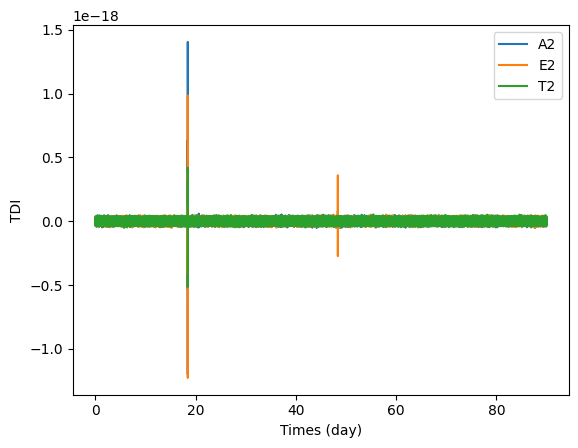

In [34]:
a2_ds = downsampling(tdi.measurements["A2"][1500:-1500], fsample, 5, [240, 0.04, 0.16])[100:-100] # drop more points at the edges to remove the invalid data caused by downsmpling 
e2_ds = downsampling(tdi.measurements["E2"][1500:-1500], fsample, 5, [240, 0.04, 0.16])[100:-100]
t2_ds = downsampling(tdi.measurements["T2"][1500:-1500], fsample, 5, [240, 0.04, 0.16])[100:-100]

time_ds = ((data_dict["time"][1500:-1500])[::5])[100:-100]

plt.plot(time_ds / DAY, a2_ds, label="A2")
plt.plot(time_ds / DAY, e2_ds, label="E2")
plt.plot(time_ds / DAY, t2_ds, label="T2")

plt.xlabel("Times (day)")
plt.ylabel("TDI")
plt.legend(loc="upper right")

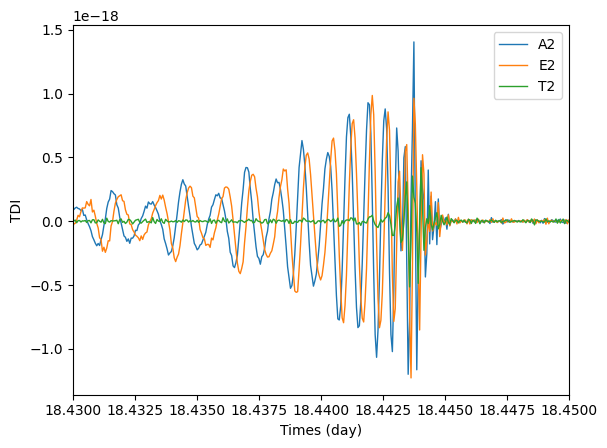

In [39]:
# zoom in 
plt.plot(time_ds / DAY, a2_ds, label="A2", linewidth=1)
plt.plot(time_ds / DAY, e2_ds, label="E2", linewidth=1)
plt.plot(time_ds / DAY, t2_ds, label="T2", linewidth=1)

plt.xlim(18.43, 18.45)
plt.xlabel("Times (day)")
plt.ylabel("TDI")
plt.legend(loc="upper right")